# project cumulative displacement onto downslope and vertical

In [259]:
# Import required packages
import os
import numpy as np
import pandas as pd
import rasterio as rio
import matplotlib.pyplot as plt
import xarray as xr
import datetime as dt
import rioxarray
import geopandas as gpd
from glob import glob
import gc
from matplotlib.dates import DateFormatter
import xdem
import seaborn as sns

In [66]:
# functions to load in mintpy data

# function to rewrite coordinates from metadata
def coord_range(ds):
    latrange = np.linspace(float(ds.attrs['Y_FIRST']),
                           ((float(ds.attrs['Y_STEP'])*float(ds.attrs['LENGTH']))+float(ds.attrs['Y_FIRST'])),
                           int(ds.attrs['LENGTH']))
    lonrange = np.linspace(float(ds.attrs['X_FIRST']),
                           ((float(ds.attrs['X_STEP'])*float(ds.attrs['WIDTH']))+float(ds.attrs['X_FIRST'])),
                           int(ds.attrs['WIDTH']))
    return latrange, lonrange

# function to read time series into xarray
def mintpyTS_to_xarray(fn, crs):
    ds = xr.open_dataset(fn, cache=False)
    ds = ds.rename_dims({'phony_dim_1':'time',
                         'phony_dim_2':'y',
                         'phony_dim_3':'x'})
    ds = ds.rename({'timeseries': 'displacement'})
    latrange, lonrange = coord_range(ds)
    ds = ds.assign_coords({'time': ('time', pd.to_datetime(ds.date)),
                           'y': ('y', latrange),
                           'x': ('x', lonrange)})
    ds = ds.drop(['bperp', 'date'])
    ds = ds.rio.write_crs(crs)
    
    return ds

def mintpy2d_to_xarray(fn, crs):
    ds = xr.open_dataset(fn, engine="h5netcdf", phony_dims='sort')
    ds = ds.rename_dims({'phony_dim_0':'y',
                         'phony_dim_1':'x'
                        })
    latrange, lonrange = coord_range(ds)
    ds = ds.assign_coords({'y': ('y', latrange),
                           'x': ('x', lonrange)})
    ds = ds.rio.write_crs(crs)
    
    return ds

def mintpyInputs_to_xarray(fn, crs):
    ds = xr.open_dataset(fn)
    ds = ds.rename_dims({'phony_dim_0':'reference_time',
                         'phony_dim_1':'secondary_time',
                         'phony_dim_2':'y',
                         'phony_dim_3':'x'})
    latrange, lonrange = coord_range(ds)
    ds = ds.assign_coords({'reference_time': ('reference_time', pd.to_datetime([span[0] for span in ds.date.values])),
                           'secondary_time': ('secondary_time', pd.to_datetime([span[1] for span in ds.date.values])),
                           'y': ('y', latrange),
                           'x': ('x', lonrange)})
    ds = ds.drop('date')
    ds = ds.rio.write_crs(crs)
    
    return ds

In [18]:
crs = 32645
asc_ts_fn = './data/asc_timeseries.h5'
asc_ts_ds = mintpyTS_to_xarray(asc_ts_fn, crs)
asc_ts_ds = asc_ts_ds.rename({'displacement': 'asc_displacement'})

des_ts_fn = './data/des_timeseries.h5'
des_ts_ds = mintpyTS_to_xarray(des_ts_fn, crs)
des_ts_ds = des_ts_ds.rename({'displacement': 'des_displacement'})

In [43]:
ts_ds = asc_ts_ds.assign(des_displacement=des_ts_ds.interp(time=asc_ts_ds.time).des_displacement.astype(np.float32))
# set start to 0 
ts_ds['des_displacement'] = ts_ds['des_displacement'] - ts_ds['des_displacement'].isel(time=0)

In [23]:
ts_ds

<xarray.Dataset>
Dimensions:           (time: 180, y: 560, x: 892)
Coordinates:
  * time              (time) datetime64[ns] 2017-01-23 2017-02-04 ... 2024-01-23
  * y                 (y) float64 3.094e+06 3.094e+06 ... 3.083e+06 3.083e+06
  * x                 (x) float64 4.8e+05 4.8e+05 ... 4.978e+05 4.979e+05
    spatial_ref       int64 0
Data variables:
    asc_displacement  (time, y, x) float32 ...
    des_displacement  (time, y, x) float32 0.007215 0.00895 ... 0.007547 -0.5048
Attributes: (12/143)
    ALOOKS:                                        1
    ANTENNA_SIDE:                                  -1
    AZIMUTH_PIXEL_SIZE:                            14.1
    BANDS:                                         1
    CENTER_LINE_UTC:                               1546.868609
    DATA_TYPE:                                     float32
    ...                                            ...
    START_DATE:                                    20170123
    END_DATE:                                      20240216
    mintpy.networkInversion.obsDatasetName:        unwrapPhase_bridging_phase...
    mintpy.networkInversion.numIfgram:             237
    UNIT:                                          m
    REF_DATE:                                      20170123

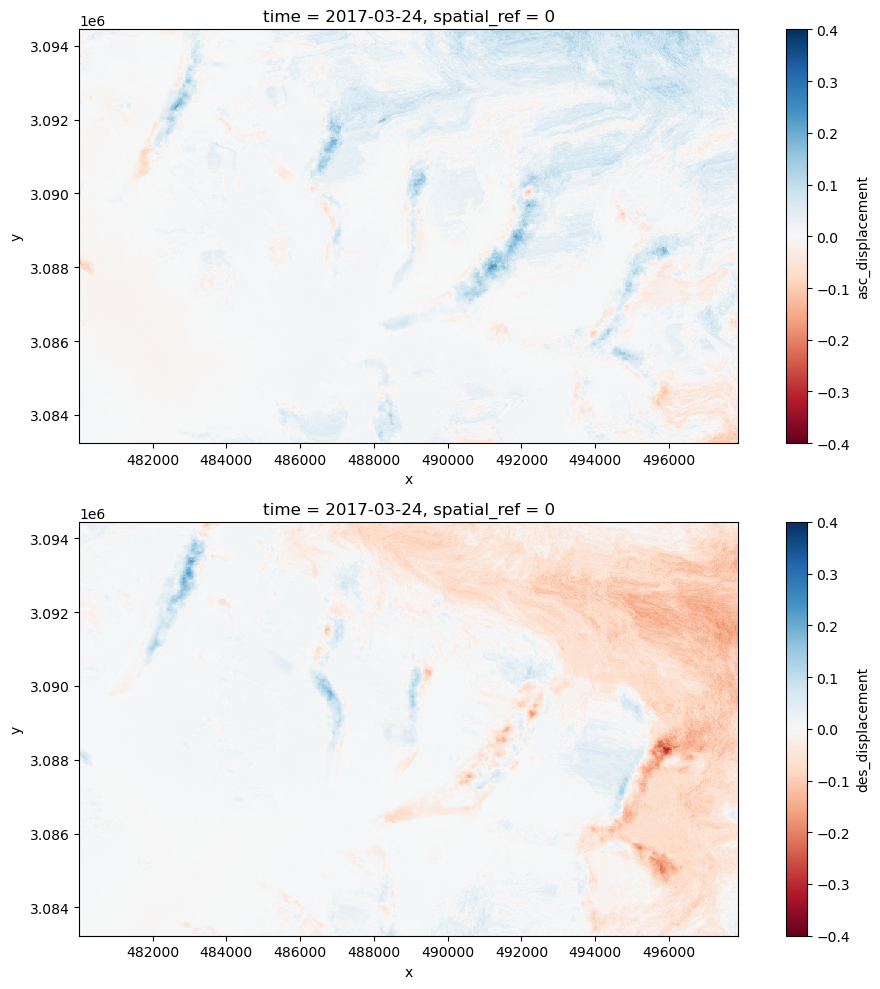

In [46]:
time_index = 5
f, ax = plt.subplots(2, 1, figsize=(10, 10))
ts_ds.asc_displacement.isel(time=time_index).plot(ax=ax[0], cmap='RdBu', vmin=-0.4, vmax=0.4)
ts_ds.des_displacement.isel(time=time_index).plot(ax=ax[1], cmap='RdBu', vmin=-0.4, vmax=0.4)
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
plt.tight_layout()

In [199]:
asc_geom_fn = './data/asc_geometryGeo.h5'
des_geom_fn = './data/des_geometryGeo.h5'
asc_geom_ds = mintpy2d_to_xarray(asc_geom_fn, crs)
des_geom_ds = mintpy2d_to_xarray(des_geom_fn, crs)

In [200]:
des_geom_ds.azimuthAngle.values

array([[-100.476715, -100.47688 , -100.476974, ..., -100.560646,
        -100.56074 , -100.56084 ],
       [-100.47681 , -100.47689 , -100.47697 , ..., -100.560646,
        -100.56074 , -100.56084 ],
       [-100.47681 , -100.4769  , -100.47697 , ..., -100.56063 ,
        -100.56074 , -100.56084 ],
       ...,
       [-100.49039 , -100.4905  , -100.49063 , ..., -100.58207 ,
        -100.582275, -100.58251 ],
       [-100.49036 , -100.49048 , -100.4907  , ..., -100.58205 ,
        -100.582344, -100.58248 ],
       [-100.4905  , -100.49057 , -100.49062 , ..., -100.58203 ,
        -100.58231 , -100.582535]], dtype=float32)

In [201]:
# define azimuth angle from sensor to target relative to north
asc_geom_ds['azimuthAngle'] =  90 - (asc_geom_ds['azimuthAngle'] - 90)
des_geom_ds['azimuthAngle'] = np.abs(des_geom_ds['azimuthAngle'] + 90) + 270

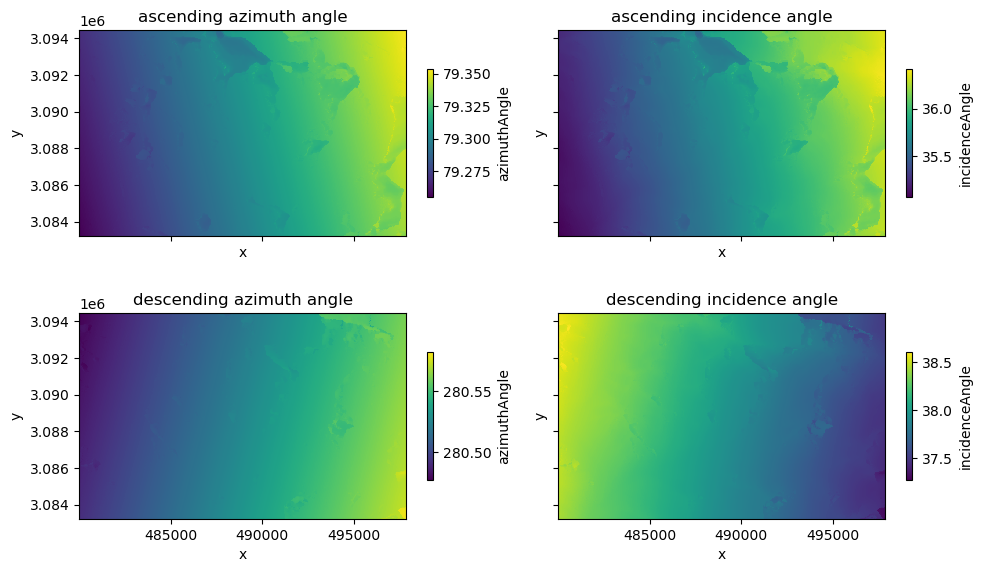

In [203]:
f, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
asc_geom_ds.azimuthAngle.plot(ax=ax[0,0], cbar_kwargs={'shrink': 0.5})
asc_geom_ds.incidenceAngle.plot(ax=ax[0,1], cbar_kwargs={'shrink': 0.5})
des_geom_ds.azimuthAngle.plot(ax=ax[1,0], cbar_kwargs={'shrink': 0.5})
des_geom_ds.incidenceAngle.plot(ax=ax[1,1], cbar_kwargs={'shrink': 0.5})
ax[0, 0].set_aspect('equal')
ax[0, 1].set_aspect('equal')
ax[1, 0].set_aspect('equal')
ax[1, 1].set_aspect('equal')
ax[0, 0].set_title('ascending azimuth angle')
ax[0, 1].set_title('ascending incidence angle')
ax[1, 0].set_title('descending azimuth angle')
ax[1, 1].set_title('descending incidence angle')
f.tight_layout()

In [204]:
# construct unit look vectors 
asc_geom_ds['n_hat'] = np.cos(np.radians(asc_geom_ds.azimuthAngle))*np.sin(np.radians(asc_geom_ds.incidenceAngle))
asc_geom_ds['e_hat'] = np.sin(np.radians(asc_geom_ds.azimuthAngle))*np.sin(np.radians(asc_geom_ds.incidenceAngle))
asc_geom_ds['z_hat'] = np.cos(np.radians(asc_geom_ds.incidenceAngle))

des_geom_ds['n_hat'] = np.cos(np.radians(des_geom_ds.azimuthAngle))*np.sin(np.radians(des_geom_ds.incidenceAngle))
des_geom_ds['e_hat'] = np.sin(np.radians(des_geom_ds.azimuthAngle))*np.sin(np.radians(des_geom_ds.incidenceAngle))
des_geom_ds['z_hat'] = np.cos(np.radians(des_geom_ds.incidenceAngle))

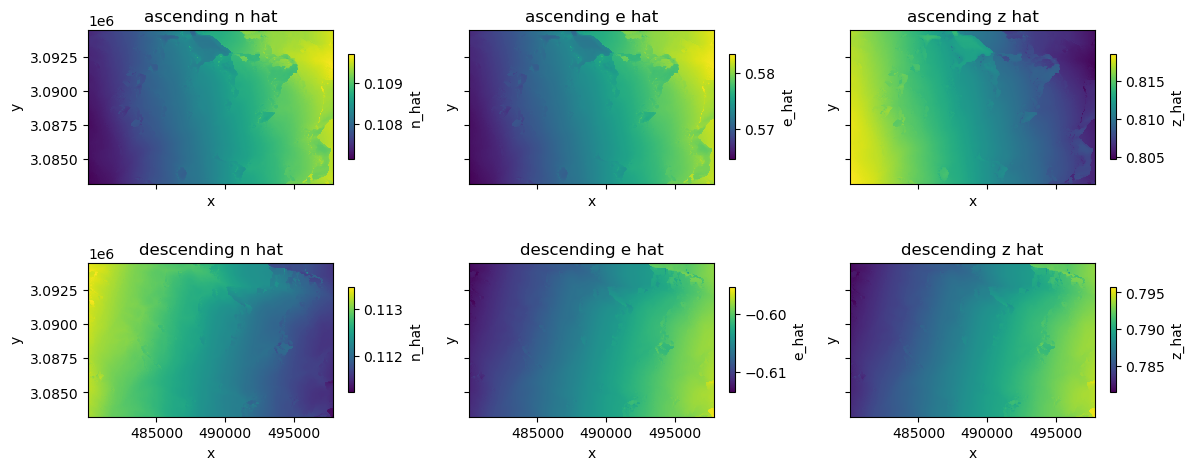

In [205]:
f, ax = plt.subplots(2, 3, figsize=(12, 5), sharex=True, sharey=True)
asc_geom_ds.n_hat.plot(ax=ax[0, 0], cbar_kwargs={'shrink': 0.5})
asc_geom_ds.e_hat.plot(ax=ax[0, 1], cbar_kwargs={'shrink': 0.5})
asc_geom_ds.z_hat.plot(ax=ax[0, 2], cbar_kwargs={'shrink': 0.5})

des_geom_ds.n_hat.plot(ax=ax[1, 0], cbar_kwargs={'shrink': 0.5})
des_geom_ds.e_hat.plot(ax=ax[1, 1], cbar_kwargs={'shrink': 0.5})
des_geom_ds.z_hat.plot(ax=ax[1, 2], cbar_kwargs={'shrink': 0.5})
ax[0, 0].set_aspect('equal')
ax[0, 1].set_aspect('equal')
ax[0, 2].set_aspect('equal')
ax[1, 0].set_aspect('equal')
ax[1, 1].set_aspect('equal')
ax[1, 2].set_aspect('equal')

ax[0, 0].set_title('ascending n hat')
ax[0, 1].set_title('ascending e hat')
ax[0, 2].set_title('ascending z hat')
ax[1, 0].set_title('descending n hat')
ax[1, 1].set_title('descending e hat')
ax[1, 2].set_title('descending z hat')
f.tight_layout()

In [206]:
# construct vertical unit vector
vertical_unit_vector = np.array([np.zeros_like(des_geom_ds['n_hat'].values), np.zeros_like(des_geom_ds['n_hat'].values), np.ones_like(des_geom_ds['n_hat'].values)])

In [207]:
# load dem from file, for now
dem_fn = '../hyp3-isce2/data/data_igrams/20170123_20170204/S1_023790_IW1_20170123_20170204_VV_INT20_4537/S1_023790_IW1_20170123_20170204_VV_INT20_4537_dem_aoi.tif'
dem = xdem.DEM(dem_fn)
aspect = xdem.terrain.aspect(dem)

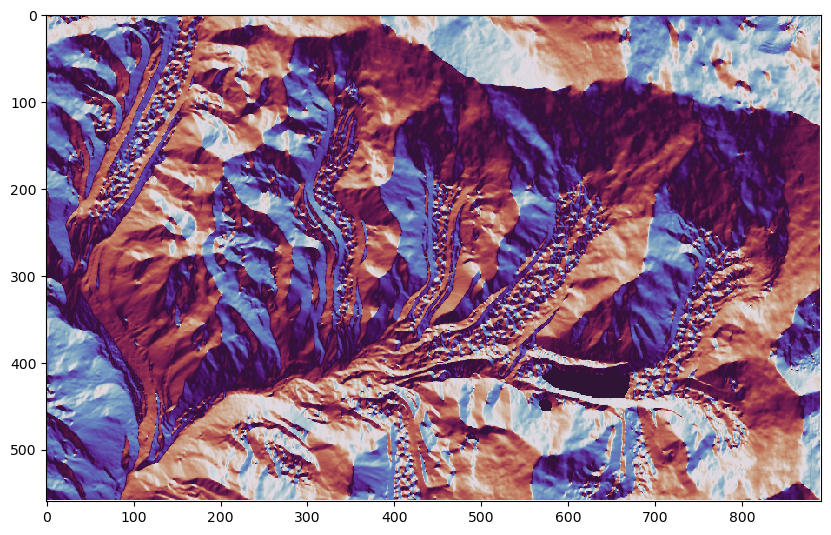

In [208]:
f, ax = plt.subplots(figsize=(10, 10))
ax.imshow(aspect.data.data, cmap='twilight', interpolation='none')

In [233]:
# horizontal unit vector 
# # using aspect:
# horizontal_unit_vector = np.array([np.cos(np.radians(aspect.data.data)), np.sin(np.radians(aspect.data.data)), np.zeros_like(des_geom_ds['n_hat'].values)])
# assuming all east/west:
horizontal_unit_vector = np.array([np.zeros_like(des_geom_ds['n_hat'].values), np.ones_like(des_geom_ds['n_hat'].values), np.zeros_like(des_geom_ds['n_hat'].values)])

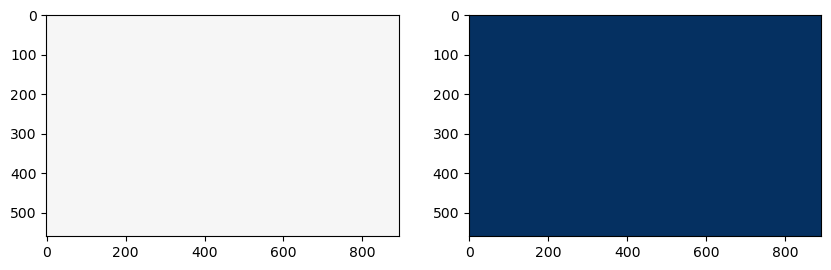

In [234]:
# check out n/s and e/w components
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(horizontal_unit_vector[0], cmap='RdBu', vmin=-1, vmax=1)
ax[1].imshow(horizontal_unit_vector[1], cmap='RdBu', vmin=-1, vmax=1)

In [235]:
# find dot products for LOS
asc_vertical = np.einsum('ijk,ijk->jk', np.array([asc_geom_ds['n_hat'].values, asc_geom_ds['e_hat'].values, asc_geom_ds['z_hat'].values]), vertical_unit_vector)
asc_horizontal = np.einsum('ijk,ijk->jk', np.array([asc_geom_ds['n_hat'].values, asc_geom_ds['e_hat'].values, asc_geom_ds['z_hat'].values]), horizontal_unit_vector)
des_vertical = np.einsum('ijk,ijk->jk', np.array([des_geom_ds['n_hat'].values, des_geom_ds['e_hat'].values, des_geom_ds['z_hat'].values]), vertical_unit_vector)
des_horizontal = np.einsum('ijk,ijk->jk', np.array([des_geom_ds['n_hat'].values, des_geom_ds['e_hat'].values, des_geom_ds['z_hat'].values]), horizontal_unit_vector)

Text(0.5, 1.0, 'descending horizontal')

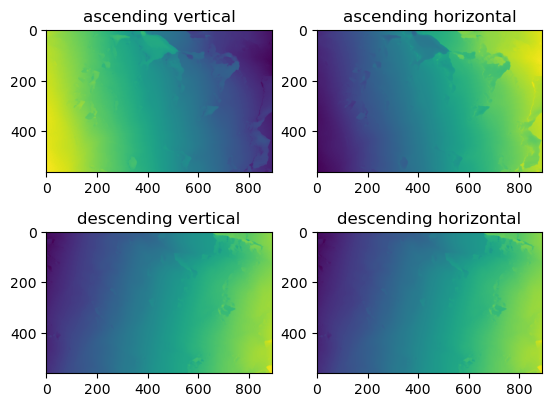

In [236]:
f, ax = plt.subplots(2, 2)
ax[0, 0].imshow(asc_vertical)
ax[0, 0].set_title('ascending vertical')
ax[0, 1].imshow(asc_horizontal)
ax[0, 1].set_title('ascending horizontal')
ax[1, 0].imshow(des_vertical)
ax[1, 0].set_title('descending vertical')
ax[1, 1].imshow(des_horizontal)
ax[1, 1].set_title('descending horizontal')

In [245]:
# solve for horizontal and vertical displacement at arbitrary time step
time_index = 20
z = (asc_horizontal*ts_ds.des_displacement.isel(time=time_index) - des_horizontal*ts_ds.asc_displacement.isel(time=time_index))/(asc_horizontal*des_vertical - des_horizontal*asc_vertical)
h = ((asc_vertical*z) - ts_ds.asc_displacement.isel(time=time_index))/-asc_horizontal

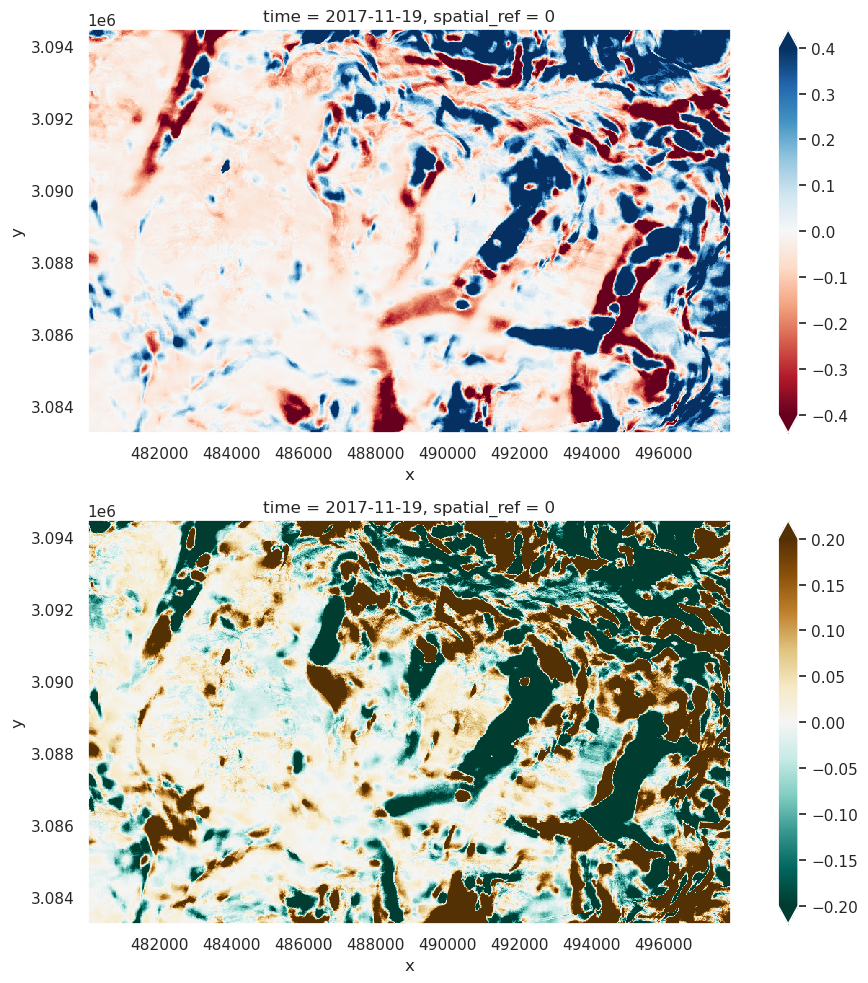

In [271]:
f, ax = plt.subplots(2, 1, figsize=(10, 10))
z.plot(ax=ax[0], vmin=-0.4, vmax=0.4, cmap='RdBu')
(h*-1).plot(ax=ax[1], vmin=-0.2, vmax=0.2, cmap='BrBG_r')
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
f.tight_layout()
plt.savefig('./figs/imja_decomp.png', dpi=300)

In [247]:
# solve for horizontal and vertical displacement for all dates 
time_index = 20
ts_ds['vertical_displacement'] = (asc_horizontal*ts_ds.des_displacement - des_horizontal*ts_ds.asc_displacement)/(asc_horizontal*des_vertical - des_horizontal*asc_vertical)
ts_ds['horizontal_displacement'] = ((asc_vertical*ts_ds['vertical_displacement']) - ts_ds.asc_displacement)/-asc_horizontal

In [248]:
imja_moraine_fn = '../../../mapping/imja_moraine.shp'
imja_moraine_gdf = gpd.read_file(imja_moraine_fn)
imja_moraine_gdf = imja_moraine_gdf.to_crs('32645')

In [250]:
imja_moraine = ts_ds.rio.clip(imja_moraine_gdf.geometry, crs=imja_moraine_gdf.crs, drop=True)

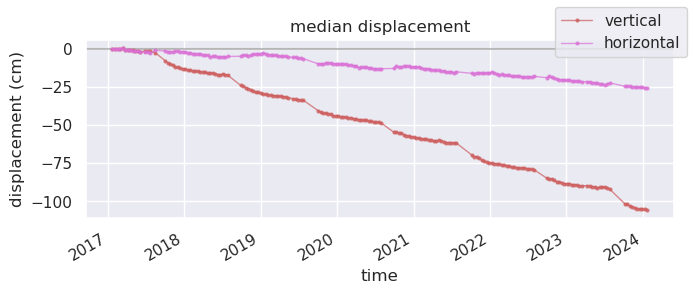

In [268]:
sns.set_theme()
f, ax = plt.subplots(figsize=(7,3))
ax.axhline(y=0, c='gray', alpha=0.5)
(imja_moraine.vertical_displacement.median(dim=('x', 'y'))*100).plot(ax=ax, c='indianred', marker='o', markersize=2, linewidth=1, alpha=0.7, label='vertical')
(imja_moraine.horizontal_displacement.median(dim=('x', 'y'))*100).plot(ax=ax, c='orchid', marker='o', markersize=2, linewidth=1, alpha=0.7, label='horizontal')
ax.set_ylabel('displacement (cm)')
ax.set_title('median displacement')
f.tight_layout()
f.legend()
plt.savefig('./figs/imja_ts.png', dpi=300)

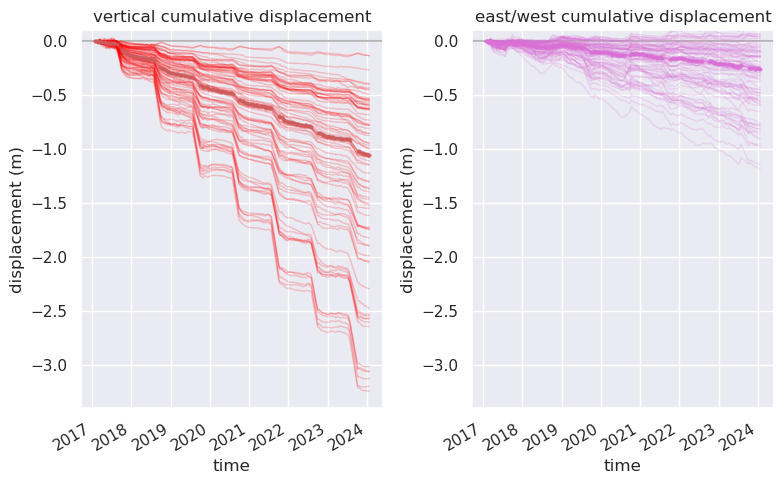

In [267]:
f, ax = plt.subplots(1, 2, figsize=(8,5))
ax[0].axhline(y=0, c='gray', alpha=0.5)
for x in range(len(imja_moraine.x)):
    for y in range(len(imja_moraine.y)):
        if (x+1) % 3 + (y+1) % 3 == 0:
            imja_moraine.vertical_displacement.isel(x=x, y=y).plot(ax=ax[0], c='red', linewidth=1, alpha=0.2)
(imja_moraine.vertical_displacement.median(dim=('x', 'y'))).plot(ax=ax[0], c='indianred', marker='o', markersize=2, linewidth=1, alpha=0.7)

ax[1].axhline(y=0, c='gray', alpha=0.5)
for x in range(len(imja_moraine.x)):
    for y in range(len(imja_moraine.y)):
        if (x+1) % 3 + (y+1) % 3 == 0:
            imja_moraine.horizontal_displacement.isel(x=x, y=y).plot(ax=ax[1], c='orchid', linewidth=1, alpha=0.2)
(imja_moraine.horizontal_displacement.median(dim=('x', 'y'))).plot(ax=ax[1], c='orchid', marker='o', markersize=2, linewidth=1, alpha=0.7)

ax[0].set_title('vertical cumulative displacement')
ax[0].set_ylabel('displacement (m)')
ax[0].set_ylim(-3.40, 0.1)
ax[1].set_title('east/west cumulative displacement')
ax[1].set_ylabel('displacement (m)')
ax[1].set_ylim(-3.40, 0.1)
f.tight_layout()
plt.savefig('./figs/imja_decomp_pixels_ts.png', dpi=300)